# Data modelling variation
**Part V**

In this section I aim to get the best regression model I can obtain with the sklearn package while ignoring all the restrictions of OLS needed for Linear regression. All the data variables that were eliminated have been included

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
housing_raw = pd.read_csv('data/housing_processed.csv')
# Dropping  ocean_proximity_NEAR BAY to prevent collinearity between columns
# 0 0 0 0 is correlated with 1
housing_data = housing_raw[['median_house_value','log_median_house_value','sqrt_median_house_value','sqr_median_house_value','in_city','median_income', # main variables
                            'log_person/room','log_person/household', 'log_room/person', 'log_household/person',
                            'sqrt_person/room','sqrt_person/household', 'sqrt_room/person', 'sqrt_household/person',
                             'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN']] # ocean variables

In [3]:
housing = housing_raw[['log_median_house_value','median_income','in_city','total_rooms','total_bedrooms','population','households',
 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND','ocean_proximity_ISLAND', 'ocean_proximity_NEAR OCEAN','sf_dist','la_dist','sd_dist',
 'person/bedroom','log_person/room','log_person/household','sqrt_room/person','sqrt_household/person']]

x = housing.iloc[:,1:]
y = pd.DataFrame(housing.iloc[:,0])

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_validate, x_test, y_validate, y_test = train_test_split(x_test, y_test, test_size=0.5)

In [5]:
print(len(x_train), len(y_train))
print(len(x_validate), len(y_validate))
print(len(x_test), len(y_test))

14232 14232
3050 3050
3050 3050


## Blackbox predictive models
#### These models are from the sklearn package and I will use the same metrics as the linear regression model to compare them. I will predict log(income) because of the right skewed distribution of income, and choose the predictor (indep) variables for them based on the models

Models used:
* Decision Tree Regressor
* Random Forest Regressor
* Elastic Net regression

## Decision Tree Regressor

In [48]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)

param_grid = {'criterion':['mse','friedman_mse'], 
              'max_depth':list(range(20,30)), 
              'min_samples_split':[2, 1, 0.01, 0.0025, 0.005],
              'min_samples_leaf':[3, 2, 1, 0.0025, 0.005, 0.01], 
              'max_features':[3,4,5]}

gridsearch_dtr = GridSearchCV(estimator = dtr,
                     param_grid = param_grid,
                     scoring = 'neg_root_mean_squared_error',
                     n_jobs = 6,
                     cv = None, #Turning off cross fold validation for performance
                     refit= True, 
                     return_train_score = False)

gridsearch_dtr.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=6,
             param_grid={'criterion': ['mse', 'friedman_mse'],
                         'max_depth': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
                         'max_features': [3, 4, 5],
                         'min_samples_leaf': [3, 2, 1, 0.0025, 0.005, 0.01],
                         'min_samples_split': [2, 1, 0.01, 0.0025, 0.005]},
             scoring='neg_root_mean_squared_error')

In [49]:
gridsearch_dtr.best_params_

{'criterion': 'mse',
 'max_depth': 21,
 'max_features': 5,
 'min_samples_leaf': 0.0025,
 'min_samples_split': 2}

training data


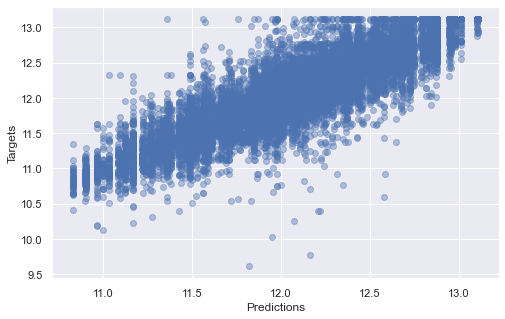

RMSE: 0.27392508875301924
MAE: 0.20179510175293142
testing data


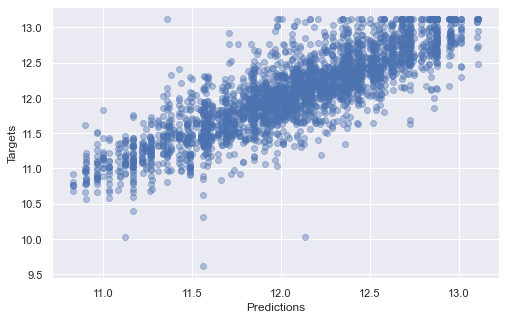

RMSE: 0.2943756556736897
MAE: 0.2178918812021997


In [71]:
print('training data')
y_hat = gridsearch_dtr.predict(x_train)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_train, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_train, y_hat)))
print('MAE:', mean_absolute_error(y_train, y_hat))

print('testing data')
y_hat = gridsearch_dtr.predict(x_validate)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_validate, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_validate, y_hat)))
print('MAE:', mean_absolute_error(y_validate, y_hat))

In [72]:
y_table = y_validate.copy()
y_table['actual y'] = np.exp(y_table['log_median_house_value'])
y_table['predicted y'] = np.exp(y_hat)
y_table['difference'] = np.abs(y_table['actual y']-y_table['predicted y'])
y_table['difference %'] = y_table['difference']/y_table['predicted y']

y_table

,log_median_house_value,actual y,predicted y,difference,difference %
8458,12.853699,382200.0,336195.753362,46004.246638,0.136838
1780,11.410893,90300.0,122998.750063,32698.750063,0.265846
16002,11.378251,87400.0,101960.169237,14560.169237,0.142803
15855,12.739051,340800.0,337065.798149,3734.201851,0.011079
11997,12.005180,163600.0,150461.711528,13138.288472,0.087320
...,...,...,...,...,...
3499,12.510612,271200.0,331496.393855,60296.393855,0.181892
19671,11.643076,113900.0,101307.167020,12592.832980,0.124303
8020,12.201562,199100.0,191847.862114,7252.137886,0.037802
1801,10.021271,22500.0,186398.686950,163898.686950,0.879291


In [73]:
print('mean % difference: {}'.format(y_table['difference %'].mean()))
print('mean difference: {}'.format(y_table['difference'].mean()))

mean % difference: 0.22748469369102753
mean difference: 44063.361553172086


## Random forest regressor

In [42]:
rfr = RandomForestRegressor()
rfr.fit(x_train.values.squeeze(), y_train.values.squeeze())

RandomForestRegressor()

In [13]:
rfr = RandomForestRegressor()
param_grid = {'min_samples_split':[4,3,2,1,0.01],
              'min_samples_leaf':[4,3,2,1,0.0025]}

gridsearch_rfr = GridSearchCV(estimator = rfr,
                     param_grid = param_grid,
                     scoring = 'neg_root_mean_squared_error',
                     n_jobs = 6,
                     cv = None,
                     refit= True, 
                     return_train_score = False)

gridsearch_rfr.fit(x_train.values.squeeze(), y_train.values.squeeze())

gridsearch_rfr.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 2}

training data


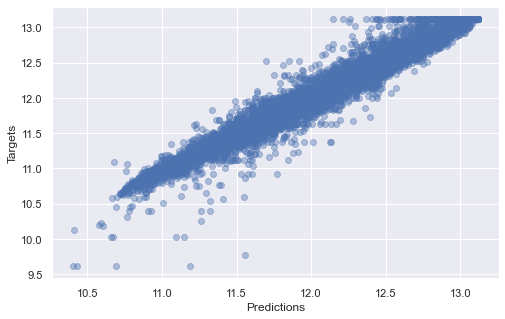

RMSE: 0.11419754995985387
MAE: 0.07332541936581788

testing data


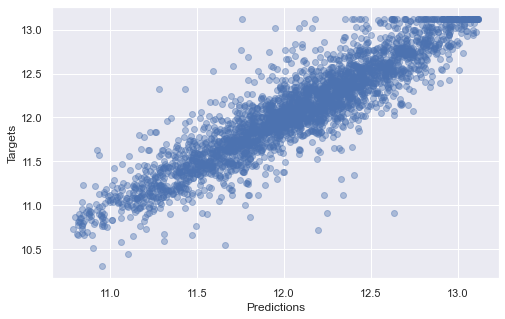

RMSE: 0.23070434757251693
MAE: 0.16486005215762137


In [20]:
print('training data')
y_hat = gridsearch_rfr.predict(x_train)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_train, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_train, y_hat)))
print('MAE:', mean_absolute_error(y_train, y_hat))

print('\ntesting data')
y_hat = gridsearch_rfr.predict(x_validate)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_validate, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_validate, y_hat)))
print('MAE:', mean_absolute_error(y_validate, y_hat))

In [21]:
y_table = y_validate.copy()
y_table['actual y'] = np.exp(y_table['log_median_house_value'])
y_table['predicted y'] = np.exp(y_hat)
y_table['difference'] = np.abs(y_table['actual y']-y_table['predicted y'])
y_table['difference %'] = y_table['difference']/y_table['predicted y']

y_table

,log_median_house_value,actual y,predicted y,difference,difference %
13584,11.429544,92000.0,104336.771944,12336.771944,0.118240
1267,11.934920,152500.0,178064.001804,25564.001804,0.143566
6766,12.123777,184200.0,150468.383557,33731.616443,0.224177
16739,12.509505,270900.0,234797.450702,36102.549298,0.153760
10142,12.353199,231700.0,315093.860228,83393.860228,0.264664
...,...,...,...,...,...
19344,11.987295,160700.0,127128.517230,33571.482770,0.264075
19955,11.913713,149300.0,176613.640898,27313.640898,0.154652
4437,11.831379,137500.0,134708.298471,2791.701529,0.020724
7849,11.999663,162700.0,170247.307217,7547.307217,0.044331


In [22]:
print('mean % difference: {}'.format(y_table['difference %'].mean()))
print('mean difference: {}'.format(y_table['difference'].mean()))

mean % difference: 0.169916888164275
mean difference: 32916.448045069104


## Elastic net regression

In [36]:
enr = ElasticNet()

param_grid = {'alpha': [0.001, 0.01, 0.025, 0.05, 0.1, 0.5, 1],
             'l1_ratio':[0.001, 0.01, 0.025, 0.05, 0.1, 0.5, 1]}

gridsearch_enr = GridSearchCV(estimator = enr,
                     param_grid = param_grid,
                     scoring = 'neg_root_mean_squared_error',
                     n_jobs = 6,
                     cv = None,
                     refit= True, 
                     return_train_score = False)

gridsearch_enr.fit(x_train.values.squeeze(), y_train.values.squeeze())

GridSearchCV(estimator=ElasticNet(), n_jobs=6,
             param_grid={'alpha': [0.001, 0.01, 0.025, 0.05, 0.1, 0.5, 1],
                         'l1_ratio': [0.001, 0.01, 0.025, 0.05, 0.1, 0.5, 1]},
             scoring='neg_root_mean_squared_error')

In [37]:
gridsearch_enr.best_params_

{'alpha': 0.001, 'l1_ratio': 0.001}

training data


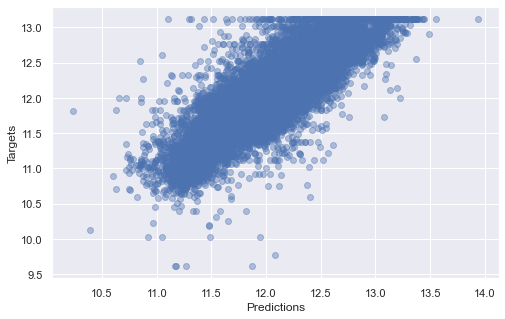

RMSE: 0.30910966871708706
MAE: 0.23244950732105954

testing data


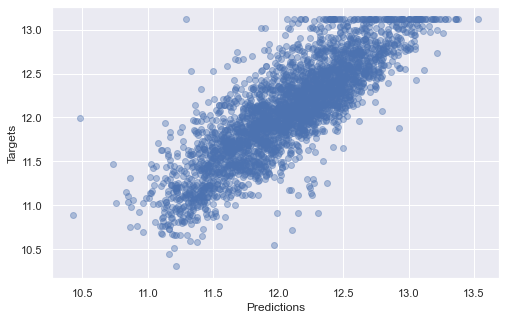

RMSE: 0.30826674428650114
MAE: 0.23445913455165435


In [38]:
print('training data')
y_hat = gridsearch_enr.predict(x_train)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_train, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_train, y_hat)))
print('MAE:', mean_absolute_error(y_train, y_hat))

print('\ntesting data')
y_hat = gridsearch_enr.predict(x_validate)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_validate, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_validate, y_hat)))
print('MAE:', mean_absolute_error(y_validate, y_hat))

In [39]:
y_table = y_validate.copy()
y_table['actual y'] = np.exp(y_table['log_median_house_value'])
y_table['predicted y'] = np.exp(y_hat)
y_table['difference'] = np.abs(y_table['actual y']-y_table['predicted y'])
y_table['difference %'] = y_table['difference']/y_table['predicted y']

y_table

,log_median_house_value,actual y,predicted y,difference,difference %
13584,11.429544,92000.0,94404.343652,2404.343652,0.025469
1267,11.934920,152500.0,171350.354078,18850.354078,0.110011
6766,12.123777,184200.0,162234.402545,21965.597455,0.135394
16739,12.509505,270900.0,246033.466016,24866.533984,0.101070
10142,12.353199,231700.0,340550.921390,108850.921390,0.319632
...,...,...,...,...,...
19344,11.987295,160700.0,112229.177822,48470.822178,0.431891
19955,11.913713,149300.0,162108.099474,12808.099474,0.079010
4437,11.831379,137500.0,148906.103614,11406.103614,0.076599
7849,11.999663,162700.0,176800.086186,14100.086186,0.079752


In [40]:
print('mean % difference: {}'.format(y_table['difference %'].mean()))
print('mean difference: {}'.format(y_table['difference'].mean()))

mean % difference: 0.24849355902875556
mean difference: 45630.283828734435


## Testing the best model RFR

training data


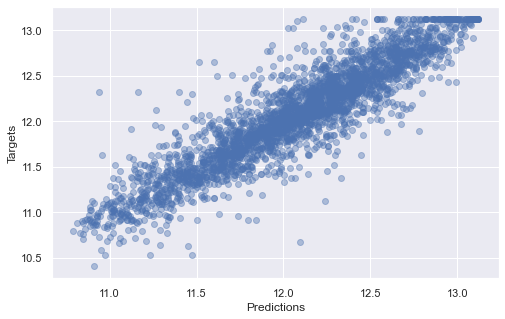

RMSE: 0.22902194653652252
MAE: 0.1640379482390565

testing data


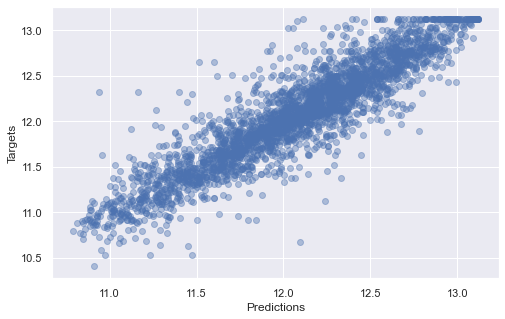

RMSE: 0.22902194653652252
MAE: 0.1640379482390565


In [43]:
print('training data')
y_hat = gridsearch_rfr.best_estimator_.predict(x_test)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_test, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat)))
print('MAE:', mean_absolute_error(y_test, y_hat))

print('\ntesting data')
y_hat = gridsearch_rfr.best_estimator_.predict(x_test)

plt.figure(figsize=(8,5))
plt.scatter(y_hat, y_test, alpha=.4)
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat)))
print('MAE:', mean_absolute_error(y_test, y_hat))

In [45]:
y_table = y_test.copy()
y_table['actual y'] = np.exp(y_table['log_median_house_value'])
y_table['predicted y'] = np.exp(y_hat)
y_table['difference'] = np.abs(y_table['actual y']-y_table['predicted y'])
y_table['difference %'] = y_table['difference']/y_table['predicted y']

print('mean % difference: {}'.format(y_table['difference %'].mean()))
print('mean difference: {}'.format(y_table['difference'].mean()))

mean % difference: 0.17048730225269962
mean difference: 32454.733067415065


# Conclusions


## Results

| Model | rmse  | mae  | mean % error | mean error |
|---:|:-------------|:-----------|:------|:------|
| Decision Tree | 0.294  | 0.218  | 0.227  | 44063.361    |
| Random Forest | 0.231  | 0.164   | 0.169   | 32916.448   |
| Lasso regression | 0.308  | 0.234   | 0.248  | 45630.284 |


**Decision Tree**

Slight improvement over part 4

**Random Forest**

Significant improvement, rmse decreased by 1/3, percentage of error decreased by 10% and value prediction is only $33,000 off the actual observation. Testing results show a constant level of performance of this model. This is the ideal model to put into production

**Lasso regression**

Slight improvement over the part 4.

**Comments**

Random forest is clearly the winner and can predict prices within 16% of their actual value

## Suggestions for improvement

The addition of more features as suggested in the conclusion of previous part. Perhaps performing principal component analysis on the entire set of engineered features before selection would yield the best performing regression model 